In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astropy.io import fits

# josh's frankenz
import frankenz as fz

%matplotlib inline

# Catalog Setup

In [4]:
# load data
data=fits.open('/Users/josephwick/Documents/College/Merian/SOM/COSMOS2015_r23.6_SOM.fits')[1].data

# extract fluxes
# we're using g,r,i,z,y band flux

# missing aphot_calib that josh uses
# has a-g, ... , a-y labels

phot_calib = np.c_[data['g_cmodel_flux'], 
                   data['r_cmodel_flux'],
                   data['i_cmodel_flux'],
                   data['z_cmodel_flux'],
                   data['y_cmodel_flux']]

err_calib = np.c_[data['g_cmodel_flux_err'], 
                  data['r_cmodel_flux_err'], 
                  data['i_cmodel_flux_err'],
                  data['z_cmodel_flux_err'],
                  data['y_cmodel_flux_err']]

mask_calib = (err_calib > 0.) & np.isfinite(err_calib) & np.isfinite(phot_calib)

# remove any sources with non-detections
sel = mask_calib.sum(axis=1) == 5
phot_calib, err_calib, mask_calib = phot_calib[sel], err_calib[sel], mask_calib[sel]

/Users/josephwick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


In [5]:
skynoise = np.median(err_calib, axis=0)
#josh used the calibration set for this

zeropoint = 10**(-0.4 * 48.6)
# unsure where these values come from
# = 3.6E-20

mag_calib, magerr_calib = fz.pdf.luptitude(phot_calib, err_calib, 
                                           skynoise=skynoise,
                                           zeropoints=zeropoint)

In [6]:
#Extract reshifts
z  = data['z']
zt = data['z_type']

# Weights

In [7]:
np.random.seed(2018)
# initialize fitting object
from frankenz.fitting import NearestNeighbors

# initialize NN object
NN = NearestNeighbors(phot_calib, err_calib, mask_calib,
                      feature_map='luptitude', K=10, 
                      fmap_args=[skynoise, zeropoint])

10/10 KDTrees constructed


In [8]:
np.random.seed(58372)

In [9]:
# generate calibration weights

# fit calibration objects
NN.fit(phot_calib, np.sqrt(err_calib**2 + (0.02*phot_calib)**2), 
       mask_calib, k=10, lprob_kwargs={'dim_prior': False})

# get calibration weights from predictions
from scipy.special import logsumexp
Ntrain, Ncalib = len(phot_calib), len(phot_calib)
calib_wts = np.zeros(Ntrain)
for i in range(Ncalib):
    n = NN.Nneighbors[i]
    idxs = NN.neighbors[i, :n]
    logwts = NN.fit_lnprob[i, :n]
    wts = np.exp(logwts - logsumexp(logwts))
    calib_wts[idxs] += wts
calib_wts *= float(Ntrain) / Ncalib

np.save('wl_weights.npy', calib_wts)

Fitting object 99411/99411


In [10]:
wts = np.load('wl_weights.npy')
# objets that get used more have larger weight

# Plotting Magnitude and Weight

In [11]:
gBand = data['g_cmodel_mag']
gBand = gBand[sel]

rBand = data['r_cmodel_mag']
rBand = rBand[sel]

iBand = data['i_cmodel_mag']
iBand = iBand[sel]

zBand = data['z_cmodel_mag']
zBand = zBand[sel]

yBand = data['y_cmodel_mag']
yBand = yBand[sel]

Text(0, 0.5, 'assigned weight')

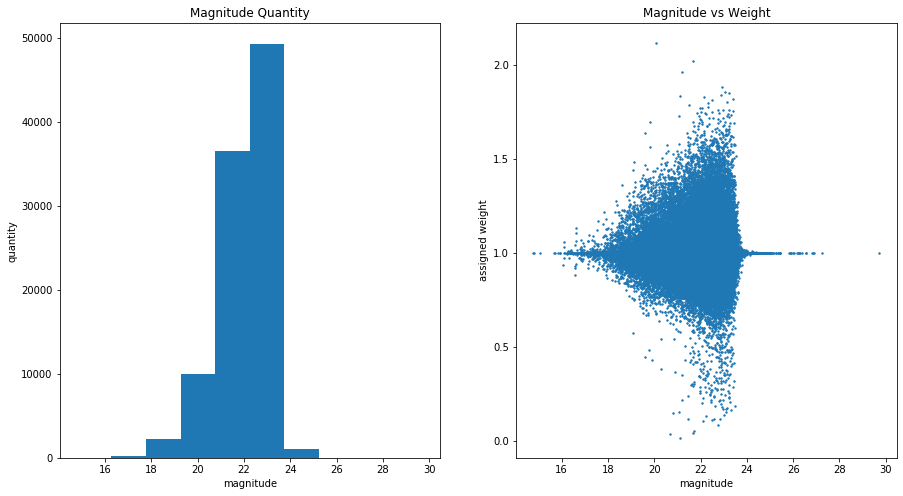

In [16]:
band = iBand

fig, axs = plt.subplots(1,2, figsize=(15, 8))

axs[0].hist(band)
axs[0].title.set_text('Magnitude Quantity')
axs[0].set_xlabel('magnitude')
axs[0].set_ylabel("quantity")

axs[1].scatter(band, wts, s=2)
axs[1].title.set_text('Magnitude vs Weight')
axs[1].set_xlabel('magnitude')
axs[1].set_ylabel('assigned weight')